**GMAIL ANALYSIS**

**IMPORT LIBRARIES** 
<br>
First step is to import all the possible libraries that would be used in this project

In [3]:
import imaplib
import email
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


from email.header import decode_header
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
from matplotlib.colors import LinearSegmentedColormap

**ENABLE IMAP ACCESS AND GENERATE GMAIL CREDENTIALS**
<br>
The second step is to "Enable IMAP access" in the "IMAP Access" section of Gmail. This will allow us to access your account from any device.
<br>
The second step is to generate an application password, which we will use to log in to Gmail from Python.
<br>
Once the password is generated, create a .yaml file with your user name and password for the newly generated application password.
<br>
Using the imaplib and email libraries access your Gmail account from Python.

In [2]:
with open('gmail.yaml') as f:
 content = f.read()
my_credentials = yaml.load(content, Loader = yaml.FullLoader)
user, password = my_credentials['user'], my_credentials['password']

In [3]:
imap_url = 'imap.gmail.com'
my_mail = imaplib.IMAP4_SSL(imap_url)
my_mail.login(user, password)

('OK', [b'damjuri0@gmail.com authenticated (Success)'])

In [4]:
my_mail.select('Inbox')

('OK', [b'23532'])

In [5]:
total_mail = int(my_mail.select('Inbox')[1][0].decode('utf-8'))
total_mail

23532

23,532 Total Inbox emails were counted

**RETRIEVE ALL THE INBOX EMAILS**

In [6]:
All_data = my_mail.search(None, 'ALL')

In [7]:
mail_ids = All_data[1]
id_list = mail_ids[0].split()
len(id_list) #This should be equal to the total number of emails you have seen above
first_email_id = int(id_list[0])
lastest_email_id = int(id_list[-1])

In [8]:
email_df = pd.DataFrame(columns=['Date','From','Subject'], index=range(lastest_email_id,first_email_id,-1))

In [9]:
for i in tqdm(range(lastest_email_id,first_email_id, -1)):
    data = my_mail.fetch(str(i),'(RFC822)')
    for response_part in data:
        arr = response_part[0]
        if isinstance(arr, tuple):
            try: msg = email.message_from_string(str(arr[1],'utf-8'))
            except: msg = email.message_from_string(str(arr[1],'latin-1'))
            new_row = pd.Series({"Date":msg['Date'] , "From":msg['from'], "Subject":msg['subject']})
            
            #email_df = email_df.append(new_row, ignore_index=True)
            email_df = pd.concat([email_df, pd.DataFrame([new_row])], ignore_index=True)

100%|██████████| 23531/23531 [1:07:30<00:00,  5.81it/s]


It took 1hour 7 minutes and 30 seconds to download 23531 Inbox emails.

In [10]:
email_df

,Date,From,Subject
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
47057,"Thu, 18 Jun 2015 02:59:00 -0700 (PDT)","""Google+"" <noreply-b3bbe73e@plus.google.com>",Top suggested Google+ Pages for you
47058,"Wed, 29 Oct 2014 16:17:16 -0400",Marvin Ellington <marvin.ellington@gmail.com>,
47059,"Sun, 31 Aug 2014 04:31:31 -0700 (PDT)","""Google+ team"" <noreply-daa26fef@plus.google.com>",Getting started on Google+
47060,"Sun, 31 Aug 2014 04:30:15 -0700",Gmail Team <mail-noreply@google.com>,Stay more organized with Gmail's inbox


In [11]:
new_row

Date            Sun, 31 Aug 2014 04:30:15 -0700
From       Gmail Team <mail-noreply@google.com>
Subject     The best of Gmail, wherever you are
dtype: object

In [12]:
email_df = email_df.dropna(how='all').reset_index(drop=True)

Drop all null columns/values

In [13]:
email_df.count()

Date       23530
From       23531
Subject    23526
dtype: int64

In [14]:
email_df.to_csv('email_df.csv', index=False, encoding='utf-8')

Save the 'email_df' dataframe to a CSV file

In [15]:
msg.keys()

['MIME-Version',
 'x-no-auto-attachment',
 'Received',
 'Date',
 'Message-ID',
 'Subject',
 'From',
 'To',
 'Content-Type']

Using msg.keys() allows you to look at all the other variables and extract them if you wish.
<br>
This is a simple analysis that focuses on creating space in the Inbox folder of our Gmai, so focusing on only 3 is the most fastest possible way to find patterns.

**DATA TRANSFORMATION AND CLEANING** 

In [16]:
def clean_date(x):
    if x is not None: 
        if "," not in x: 
            x = ', ' + x
        if "(" in x: 
            x = ' '.join(x.split(' ')[:-1])
        x = ' '.join(x.split(' ')[:-1])
    return x
    

Create a function that can extract the last parts (+0000 UTC) of the Date Column

In [17]:
email_df['H_M_S'] = email_df['Date'].apply(lambda x: clean_date(x)) # To omit Timezones (UTC) and get "Tue, 21 Nov 2023 00:14:54"

In [18]:
email_df

,Date,From,Subject,H_M_S
0,"Tue, 21 Nov 2023 00:14:54 +0000 (UTC)",LinkedIn <notifications-noreply@linkedin.com>,"=?UTF-8?Q?=F0=9F=93=A9_Daniel_Mogbojuri,_you_h...","Tue, 21 Nov 2023 00:14:54"
1,"Mon, 20 Nov 2023 23:58:11 +0000","""Yorkdale"" <info@e.yorkdale.com>",=?utf-8?B?U2FudGEgaGFzIEFycml2ZWQsIERhbmllbPCf...,"Mon, 20 Nov 2023 23:58:11"
2,"Mon, 20 Nov 2023 22:03:06 -0000","""American Express"" <AmericanExpress@email.amer...",=?UTF-8?B?RGFuaWVsLCBjbGljayB0byByZXZlYWwgeW91...,"Mon, 20 Nov 2023 22:03:06"
3,"Mon, 20 Nov 2023 21:21:06 +0000 (UTC)",CVS Health Careers <Careers@cvshealth.com>,From The Heart: A Career With Purpose,"Mon, 20 Nov 2023 21:21:06"
4,"Mon, 20 Nov 2023 20:49:28 +0000","""Uber Receipts"" <noreply@uber.com>",Your Monday morning trip with Uber,"Mon, 20 Nov 2023 20:49:28"
...,...,...,...,...
23526,"Thu, 18 Jun 2015 02:59:00 -0700 (PDT)","""Google+"" <noreply-b3bbe73e@plus.google.com>",Top suggested Google+ Pages for you,"Thu, 18 Jun 2015 02:59:00"
23527,"Wed, 29 Oct 2014 16:17:16 -0400",Marvin Ellington <marvin.ellington@gmail.com>,,"Wed, 29 Oct 2014 16:17:16"
23528,"Sun, 31 Aug 2014 04:31:31 -0700 (PDT)","""Google+ team"" <noreply-daa26fef@plus.google.com>",Getting started on Google+,"Sun, 31 Aug 2014 04:31:31"
23529,"Sun, 31 Aug 2014 04:30:15 -0700",Gmail Team <mail-noreply@google.com>,Stay more organized with Gmail's inbox,"Sun, 31 Aug 2014 04:30:15"


In [19]:
email_df['H_M_S'] = email_df['H_M_S'].str.split(', ').str[-1] # Omit weekday, and keep "21 Nov 2023 00:14:54"

In [20]:
email_df

,Date,From,Subject,H_M_S
0,"Tue, 21 Nov 2023 00:14:54 +0000 (UTC)",LinkedIn <notifications-noreply@linkedin.com>,"=?UTF-8?Q?=F0=9F=93=A9_Daniel_Mogbojuri,_you_h...",21 Nov 2023 00:14:54
1,"Mon, 20 Nov 2023 23:58:11 +0000","""Yorkdale"" <info@e.yorkdale.com>",=?utf-8?B?U2FudGEgaGFzIEFycml2ZWQsIERhbmllbPCf...,20 Nov 2023 23:58:11
2,"Mon, 20 Nov 2023 22:03:06 -0000","""American Express"" <AmericanExpress@email.amer...",=?UTF-8?B?RGFuaWVsLCBjbGljayB0byByZXZlYWwgeW91...,20 Nov 2023 22:03:06
3,"Mon, 20 Nov 2023 21:21:06 +0000 (UTC)",CVS Health Careers <Careers@cvshealth.com>,From The Heart: A Career With Purpose,20 Nov 2023 21:21:06
4,"Mon, 20 Nov 2023 20:49:28 +0000","""Uber Receipts"" <noreply@uber.com>",Your Monday morning trip with Uber,20 Nov 2023 20:49:28
...,...,...,...,...
23526,"Thu, 18 Jun 2015 02:59:00 -0700 (PDT)","""Google+"" <noreply-b3bbe73e@plus.google.com>",Top suggested Google+ Pages for you,18 Jun 2015 02:59:00
23527,"Wed, 29 Oct 2014 16:17:16 -0400",Marvin Ellington <marvin.ellington@gmail.com>,,29 Oct 2014 16:17:16
23528,"Sun, 31 Aug 2014 04:31:31 -0700 (PDT)","""Google+ team"" <noreply-daa26fef@plus.google.com>",Getting started on Google+,31 Aug 2014 04:31:31
23529,"Sun, 31 Aug 2014 04:30:15 -0700",Gmail Team <mail-noreply@google.com>,Stay more organized with Gmail's inbox,31 Aug 2014 04:30:15


In [21]:
email_df['H_M_S'] = email_df['H_M_S'].apply(lambda x: x[-8:] if (x is not None and len(x) >= 8) else 'Invalid Time') #only pick the time in Hours, Minutes & Seconds

In [22]:
email_df

,Date,From,Subject,H_M_S
0,"Tue, 21 Nov 2023 00:14:54 +0000 (UTC)",LinkedIn <notifications-noreply@linkedin.com>,"=?UTF-8?Q?=F0=9F=93=A9_Daniel_Mogbojuri,_you_h...",00:14:54
1,"Mon, 20 Nov 2023 23:58:11 +0000","""Yorkdale"" <info@e.yorkdale.com>",=?utf-8?B?U2FudGEgaGFzIEFycml2ZWQsIERhbmllbPCf...,23:58:11
2,"Mon, 20 Nov 2023 22:03:06 -0000","""American Express"" <AmericanExpress@email.amer...",=?UTF-8?B?RGFuaWVsLCBjbGljayB0byByZXZlYWwgeW91...,22:03:06
3,"Mon, 20 Nov 2023 21:21:06 +0000 (UTC)",CVS Health Careers <Careers@cvshealth.com>,From The Heart: A Career With Purpose,21:21:06
4,"Mon, 20 Nov 2023 20:49:28 +0000","""Uber Receipts"" <noreply@uber.com>",Your Monday morning trip with Uber,20:49:28
...,...,...,...,...
23526,"Thu, 18 Jun 2015 02:59:00 -0700 (PDT)","""Google+"" <noreply-b3bbe73e@plus.google.com>",Top suggested Google+ Pages for you,02:59:00
23527,"Wed, 29 Oct 2014 16:17:16 -0400",Marvin Ellington <marvin.ellington@gmail.com>,,16:17:16
23528,"Sun, 31 Aug 2014 04:31:31 -0700 (PDT)","""Google+ team"" <noreply-daa26fef@plus.google.com>",Getting started on Google+,04:31:31
23529,"Sun, 31 Aug 2014 04:30:15 -0700",Gmail Team <mail-noreply@google.com>,Stay more organized with Gmail's inbox,04:30:15


In [23]:
email_df['Hour'] = email_df['H_M_S'].apply(lambda x: x[:2]+'h-'+str(int(x[:2]) + 1).zfill(2)+'h' if x[:2].isdigit() else 'Invalid Time') #Group within hour range

In [24]:
email_df

,Date,From,Subject,H_M_S,Hour
0,"Tue, 21 Nov 2023 00:14:54 +0000 (UTC)",LinkedIn <notifications-noreply@linkedin.com>,"=?UTF-8?Q?=F0=9F=93=A9_Daniel_Mogbojuri,_you_h...",00:14:54,00h-01h
1,"Mon, 20 Nov 2023 23:58:11 +0000","""Yorkdale"" <info@e.yorkdale.com>",=?utf-8?B?U2FudGEgaGFzIEFycml2ZWQsIERhbmllbPCf...,23:58:11,23h-24h
2,"Mon, 20 Nov 2023 22:03:06 -0000","""American Express"" <AmericanExpress@email.amer...",=?UTF-8?B?RGFuaWVsLCBjbGljayB0byByZXZlYWwgeW91...,22:03:06,22h-23h
3,"Mon, 20 Nov 2023 21:21:06 +0000 (UTC)",CVS Health Careers <Careers@cvshealth.com>,From The Heart: A Career With Purpose,21:21:06,21h-22h
4,"Mon, 20 Nov 2023 20:49:28 +0000","""Uber Receipts"" <noreply@uber.com>",Your Monday morning trip with Uber,20:49:28,20h-21h
...,...,...,...,...,...
23526,"Thu, 18 Jun 2015 02:59:00 -0700 (PDT)","""Google+"" <noreply-b3bbe73e@plus.google.com>",Top suggested Google+ Pages for you,02:59:00,02h-03h
23527,"Wed, 29 Oct 2014 16:17:16 -0400",Marvin Ellington <marvin.ellington@gmail.com>,,16:17:16,16h-17h
23528,"Sun, 31 Aug 2014 04:31:31 -0700 (PDT)","""Google+ team"" <noreply-daa26fef@plus.google.com>",Getting started on Google+,04:31:31,04h-05h
23529,"Sun, 31 Aug 2014 04:30:15 -0700",Gmail Team <mail-noreply@google.com>,Stay more organized with Gmail's inbox,04:30:15,04h-05h


In [28]:
email_df

,Date,From,Subject,H_M_S,Hour,New_Date
0,"Tue, 21 Nov 2023 00:14:54 +0000 (UTC)",LinkedIn <notifications-noreply@linkedin.com>,"=?UTF-8?Q?=F0=9F=93=A9_Daniel_Mogbojuri,_you_h...",00:14:54,00h-01h,"0Tue, 21 Nov 2023 00:14:54 +0"
1,"Mon, 20 Nov 2023 23:58:11 +0000","""Yorkdale"" <info@e.yorkdale.com>",=?utf-8?B?U2FudGEgaGFzIEFycml2ZWQsIERhbmllbPCf...,23:58:11,23h-24h,"0Mon, 20 Nov 2023 23:58"
2,"Mon, 20 Nov 2023 22:03:06 -0000","""American Express"" <AmericanExpress@email.amer...",=?UTF-8?B?RGFuaWVsLCBjbGljayB0byByZXZlYWwgeW91...,22:03:06,22h-23h,"0Mon, 20 Nov 2023 22:03"
3,"Mon, 20 Nov 2023 21:21:06 +0000 (UTC)",CVS Health Careers <Careers@cvshealth.com>,From The Heart: A Career With Purpose,21:21:06,21h-22h,"0Mon, 20 Nov 2023 21:21:06 +0"
4,"Mon, 20 Nov 2023 20:49:28 +0000","""Uber Receipts"" <noreply@uber.com>",Your Monday morning trip with Uber,20:49:28,20h-21h,"0Mon, 20 Nov 2023 20:49"
...,...,...,...,...,...,...
23526,"Thu, 18 Jun 2015 02:59:00 -0700 (PDT)","""Google+"" <noreply-b3bbe73e@plus.google.com>",Top suggested Google+ Pages for you,02:59:00,02h-03h,"0Thu, 18 Jun 2015 02:59:00 -0"
23527,"Wed, 29 Oct 2014 16:17:16 -0400",Marvin Ellington <marvin.ellington@gmail.com>,,16:17:16,16h-17h,"0Wed, 29 Oct 2014 16:17"
23528,"Sun, 31 Aug 2014 04:31:31 -0700 (PDT)","""Google+ team"" <noreply-daa26fef@plus.google.com>",Getting started on Google+,04:31:31,04h-05h,"0Sun, 31 Aug 2014 04:31:31 -0"
23529,"Sun, 31 Aug 2014 04:30:15 -0700",Gmail Team <mail-noreply@google.com>,Stay more organized with Gmail's inbox,04:30:15,04h-05h,"0Sun, 31 Aug 2014 04:30"


In [37]:
email_df['New_Date'] = email_df['Date'].apply(lambda x: clean_date(x)) # To omit Timezones (UTC) and get "Tue, 21 Nov 2023 00:14:54

In [38]:
email_df

,Date,From,Subject,H_M_S,Hour,New_Date
0,"Tue, 21 Nov 2023 00:14:54 +0000 (UTC)",LinkedIn <notifications-noreply@linkedin.com>,"=?UTF-8?Q?=F0=9F=93=A9_Daniel_Mogbojuri,_you_h...",00:14:54,00h-01h,"Tue, 21 Nov 2023 00:14:54"
1,"Mon, 20 Nov 2023 23:58:11 +0000","""Yorkdale"" <info@e.yorkdale.com>",=?utf-8?B?U2FudGEgaGFzIEFycml2ZWQsIERhbmllbPCf...,23:58:11,23h-24h,"Mon, 20 Nov 2023 23:58:11"
2,"Mon, 20 Nov 2023 22:03:06 -0000","""American Express"" <AmericanExpress@email.amer...",=?UTF-8?B?RGFuaWVsLCBjbGljayB0byByZXZlYWwgeW91...,22:03:06,22h-23h,"Mon, 20 Nov 2023 22:03:06"
3,"Mon, 20 Nov 2023 21:21:06 +0000 (UTC)",CVS Health Careers <Careers@cvshealth.com>,From The Heart: A Career With Purpose,21:21:06,21h-22h,"Mon, 20 Nov 2023 21:21:06"
4,"Mon, 20 Nov 2023 20:49:28 +0000","""Uber Receipts"" <noreply@uber.com>",Your Monday morning trip with Uber,20:49:28,20h-21h,"Mon, 20 Nov 2023 20:49:28"
...,...,...,...,...,...,...
23526,"Thu, 18 Jun 2015 02:59:00 -0700 (PDT)","""Google+"" <noreply-b3bbe73e@plus.google.com>",Top suggested Google+ Pages for you,02:59:00,02h-03h,"Thu, 18 Jun 2015 02:59:00"
23527,"Wed, 29 Oct 2014 16:17:16 -0400",Marvin Ellington <marvin.ellington@gmail.com>,,16:17:16,16h-17h,"Wed, 29 Oct 2014 16:17:16"
23528,"Sun, 31 Aug 2014 04:31:31 -0700 (PDT)","""Google+ team"" <noreply-daa26fef@plus.google.com>",Getting started on Google+,04:31:31,04h-05h,"Sun, 31 Aug 2014 04:31:31"
23529,"Sun, 31 Aug 2014 04:30:15 -0700",Gmail Team <mail-noreply@google.com>,Stay more organized with Gmail's inbox,04:30:15,04h-05h,"Sun, 31 Aug 2014 04:30:15"


In [39]:
email_df['New_Date'] = email_df['New_Date'].str.split(', ').str[-1] # Omit weekday, and keep "21 Nov 2023 00:14:54"

In [40]:
email_df

,Date,From,Subject,H_M_S,Hour,New_Date
0,"Tue, 21 Nov 2023 00:14:54 +0000 (UTC)",LinkedIn <notifications-noreply@linkedin.com>,"=?UTF-8?Q?=F0=9F=93=A9_Daniel_Mogbojuri,_you_h...",00:14:54,00h-01h,21 Nov 2023 00:14:54
1,"Mon, 20 Nov 2023 23:58:11 +0000","""Yorkdale"" <info@e.yorkdale.com>",=?utf-8?B?U2FudGEgaGFzIEFycml2ZWQsIERhbmllbPCf...,23:58:11,23h-24h,20 Nov 2023 23:58:11
2,"Mon, 20 Nov 2023 22:03:06 -0000","""American Express"" <AmericanExpress@email.amer...",=?UTF-8?B?RGFuaWVsLCBjbGljayB0byByZXZlYWwgeW91...,22:03:06,22h-23h,20 Nov 2023 22:03:06
3,"Mon, 20 Nov 2023 21:21:06 +0000 (UTC)",CVS Health Careers <Careers@cvshealth.com>,From The Heart: A Career With Purpose,21:21:06,21h-22h,20 Nov 2023 21:21:06
4,"Mon, 20 Nov 2023 20:49:28 +0000","""Uber Receipts"" <noreply@uber.com>",Your Monday morning trip with Uber,20:49:28,20h-21h,20 Nov 2023 20:49:28
...,...,...,...,...,...,...
23526,"Thu, 18 Jun 2015 02:59:00 -0700 (PDT)","""Google+"" <noreply-b3bbe73e@plus.google.com>",Top suggested Google+ Pages for you,02:59:00,02h-03h,18 Jun 2015 02:59:00
23527,"Wed, 29 Oct 2014 16:17:16 -0400",Marvin Ellington <marvin.ellington@gmail.com>,,16:17:16,16h-17h,29 Oct 2014 16:17:16
23528,"Sun, 31 Aug 2014 04:31:31 -0700 (PDT)","""Google+ team"" <noreply-daa26fef@plus.google.com>",Getting started on Google+,04:31:31,04h-05h,31 Aug 2014 04:31:31
23529,"Sun, 31 Aug 2014 04:30:15 -0700",Gmail Team <mail-noreply@google.com>,Stay more organized with Gmail's inbox,04:30:15,04h-05h,31 Aug 2014 04:30:15


In [41]:
email_df['New_Date'] = email_df['New_Date'].apply(lambda x: x[:11] if (x is not None and len(x) >= 8) else 'Invalid Time') #only pick the Day, Month, and Year

In [42]:
email_df

,Date,From,Subject,H_M_S,Hour,New_Date
0,"Tue, 21 Nov 2023 00:14:54 +0000 (UTC)",LinkedIn <notifications-noreply@linkedin.com>,"=?UTF-8?Q?=F0=9F=93=A9_Daniel_Mogbojuri,_you_h...",00:14:54,00h-01h,21 Nov 2023
1,"Mon, 20 Nov 2023 23:58:11 +0000","""Yorkdale"" <info@e.yorkdale.com>",=?utf-8?B?U2FudGEgaGFzIEFycml2ZWQsIERhbmllbPCf...,23:58:11,23h-24h,20 Nov 2023
2,"Mon, 20 Nov 2023 22:03:06 -0000","""American Express"" <AmericanExpress@email.amer...",=?UTF-8?B?RGFuaWVsLCBjbGljayB0byByZXZlYWwgeW91...,22:03:06,22h-23h,20 Nov 2023
3,"Mon, 20 Nov 2023 21:21:06 +0000 (UTC)",CVS Health Careers <Careers@cvshealth.com>,From The Heart: A Career With Purpose,21:21:06,21h-22h,20 Nov 2023
4,"Mon, 20 Nov 2023 20:49:28 +0000","""Uber Receipts"" <noreply@uber.com>",Your Monday morning trip with Uber,20:49:28,20h-21h,20 Nov 2023
...,...,...,...,...,...,...
23526,"Thu, 18 Jun 2015 02:59:00 -0700 (PDT)","""Google+"" <noreply-b3bbe73e@plus.google.com>",Top suggested Google+ Pages for you,02:59:00,02h-03h,18 Jun 2015
23527,"Wed, 29 Oct 2014 16:17:16 -0400",Marvin Ellington <marvin.ellington@gmail.com>,,16:17:16,16h-17h,29 Oct 2014
23528,"Sun, 31 Aug 2014 04:31:31 -0700 (PDT)","""Google+ team"" <noreply-daa26fef@plus.google.com>",Getting started on Google+,04:31:31,04h-05h,31 Aug 2014
23529,"Sun, 31 Aug 2014 04:30:15 -0700",Gmail Team <mail-noreply@google.com>,Stay more organized with Gmail's inbox,04:30:15,04h-05h,31 Aug 2014


In [52]:
email_df['New_Date'] = email_df['New_Date'].apply(lambda x: pd.to_datetime(x, format='%d %b %Y', errors='coerce')) #Change New_Date Column format

In [53]:
email_df

,Date,From,Subject,H_M_S,Hour,New_Date
0,"Tue, 21 Nov 2023 00:14:54 +0000 (UTC)",LinkedIn <notifications-noreply@linkedin.com>,"=?UTF-8?Q?=F0=9F=93=A9_Daniel_Mogbojuri,_you_h...",00:14:54,00h-01h,2023-11-21
1,"Mon, 20 Nov 2023 23:58:11 +0000","""Yorkdale"" <info@e.yorkdale.com>",=?utf-8?B?U2FudGEgaGFzIEFycml2ZWQsIERhbmllbPCf...,23:58:11,23h-24h,2023-11-20
2,"Mon, 20 Nov 2023 22:03:06 -0000","""American Express"" <AmericanExpress@email.amer...",=?UTF-8?B?RGFuaWVsLCBjbGljayB0byByZXZlYWwgeW91...,22:03:06,22h-23h,2023-11-20
3,"Mon, 20 Nov 2023 21:21:06 +0000 (UTC)",CVS Health Careers <Careers@cvshealth.com>,From The Heart: A Career With Purpose,21:21:06,21h-22h,2023-11-20
4,"Mon, 20 Nov 2023 20:49:28 +0000","""Uber Receipts"" <noreply@uber.com>",Your Monday morning trip with Uber,20:49:28,20h-21h,2023-11-20
...,...,...,...,...,...,...
23526,"Thu, 18 Jun 2015 02:59:00 -0700 (PDT)","""Google+"" <noreply-b3bbe73e@plus.google.com>",Top suggested Google+ Pages for you,02:59:00,02h-03h,2015-06-18
23527,"Wed, 29 Oct 2014 16:17:16 -0400",Marvin Ellington <marvin.ellington@gmail.com>,,16:17:16,16h-17h,2014-10-29
23528,"Sun, 31 Aug 2014 04:31:31 -0700 (PDT)","""Google+ team"" <noreply-daa26fef@plus.google.com>",Getting started on Google+,04:31:31,04h-05h,2014-08-31
23529,"Sun, 31 Aug 2014 04:30:15 -0700",Gmail Team <mail-noreply@google.com>,Stay more organized with Gmail's inbox,04:30:15,04h-05h,2014-08-31


In [55]:
email_df['WeekDay'] = email_df['New_Date'].dt.strftime('%A') #Create New Column that has the Weekday full name

In [56]:
email_df

,Date,From,Subject,H_M_S,Hour,New_Date,WeekDay
0,"Tue, 21 Nov 2023 00:14:54 +0000 (UTC)",LinkedIn <notifications-noreply@linkedin.com>,"=?UTF-8?Q?=F0=9F=93=A9_Daniel_Mogbojuri,_you_h...",00:14:54,00h-01h,2023-11-21,Tuesday
1,"Mon, 20 Nov 2023 23:58:11 +0000","""Yorkdale"" <info@e.yorkdale.com>",=?utf-8?B?U2FudGEgaGFzIEFycml2ZWQsIERhbmllbPCf...,23:58:11,23h-24h,2023-11-20,Monday
2,"Mon, 20 Nov 2023 22:03:06 -0000","""American Express"" <AmericanExpress@email.amer...",=?UTF-8?B?RGFuaWVsLCBjbGljayB0byByZXZlYWwgeW91...,22:03:06,22h-23h,2023-11-20,Monday
3,"Mon, 20 Nov 2023 21:21:06 +0000 (UTC)",CVS Health Careers <Careers@cvshealth.com>,From The Heart: A Career With Purpose,21:21:06,21h-22h,2023-11-20,Monday
4,"Mon, 20 Nov 2023 20:49:28 +0000","""Uber Receipts"" <noreply@uber.com>",Your Monday morning trip with Uber,20:49:28,20h-21h,2023-11-20,Monday
...,...,...,...,...,...,...,...
23526,"Thu, 18 Jun 2015 02:59:00 -0700 (PDT)","""Google+"" <noreply-b3bbe73e@plus.google.com>",Top suggested Google+ Pages for you,02:59:00,02h-03h,2015-06-18,Thursday
23527,"Wed, 29 Oct 2014 16:17:16 -0400",Marvin Ellington <marvin.ellington@gmail.com>,,16:17:16,16h-17h,2014-10-29,Wednesday
23528,"Sun, 31 Aug 2014 04:31:31 -0700 (PDT)","""Google+ team"" <noreply-daa26fef@plus.google.com>",Getting started on Google+,04:31:31,04h-05h,2014-08-31,Sunday
23529,"Sun, 31 Aug 2014 04:30:15 -0700",Gmail Team <mail-noreply@google.com>,Stay more organized with Gmail's inbox,04:30:15,04h-05h,2014-08-31,Sunday


In [57]:
email_df.drop_duplicates #drop duplicate rows

<bound method DataFrame.drop_duplicates of                                         Date  \
0      Tue, 21 Nov 2023 00:14:54 +0000 (UTC)   
1            Mon, 20 Nov 2023 23:58:11 +0000   
2            Mon, 20 Nov 2023 22:03:06 -0000   
3      Mon, 20 Nov 2023 21:21:06 +0000 (UTC)   
4            Mon, 20 Nov 2023 20:49:28 +0000   
...                                      ...   
23526  Thu, 18 Jun 2015 02:59:00 -0700 (PDT)   
23527        Wed, 29 Oct 2014 16:17:16 -0400   
23528  Sun, 31 Aug 2014 04:31:31 -0700 (PDT)   
23529        Sun, 31 Aug 2014 04:30:15 -0700   
23530        Sun, 31 Aug 2014 04:30:15 -0700   

                                                    From  \
0          LinkedIn <notifications-noreply@linkedin.com>   
1                       "Yorkdale" <info@e.yorkdale.com>   
2      "American Express" <AmericanExpress@email.amer...   
3             CVS Health Careers <Careers@cvshealth.com>   
4                     "Uber Receipts" <noreply@uber.com>   
...                 

In [58]:
email_df.head(10)

,Date,From,Subject,H_M_S,Hour,New_Date,WeekDay
0,"Tue, 21 Nov 2023 00:14:54 +0000 (UTC)",LinkedIn <notifications-noreply@linkedin.com>,"=?UTF-8?Q?=F0=9F=93=A9_Daniel_Mogbojuri,_you_h...",00:14:54,00h-01h,2023-11-21,Tuesday
1,"Mon, 20 Nov 2023 23:58:11 +0000","""Yorkdale"" <info@e.yorkdale.com>",=?utf-8?B?U2FudGEgaGFzIEFycml2ZWQsIERhbmllbPCf...,23:58:11,23h-24h,2023-11-20,Monday
2,"Mon, 20 Nov 2023 22:03:06 -0000","""American Express"" <AmericanExpress@email.amer...",=?UTF-8?B?RGFuaWVsLCBjbGljayB0byByZXZlYWwgeW91...,22:03:06,22h-23h,2023-11-20,Monday
3,"Mon, 20 Nov 2023 21:21:06 +0000 (UTC)",CVS Health Careers <Careers@cvshealth.com>,From The Heart: A Career With Purpose,21:21:06,21h-22h,2023-11-20,Monday
4,"Mon, 20 Nov 2023 20:49:28 +0000","""Uber Receipts"" <noreply@uber.com>",Your Monday morning trip with Uber,20:49:28,20h-21h,2023-11-20,Monday
5,"Mon, 20 Nov 2023 13:05:32 -0600","""Walmart Rewards"" <info@walmart-rewards.ca>","DANIEL, earn 5% in Reward Dollars on Apple pro...",13:05:32,13h-14h,2023-11-20,Monday
6,"Mon, 20 Nov 2023 18:39:39 +0000 (UTC)",TD Canada Trust <notify@payments.interac.ca>,INTERAC e-Transfer: Your money transfer to OSA...,18:39:39,18h-19h,2023-11-20,Monday
7,"Mon, 20 Nov 2023 17:40:06 +0000",Albert Vo <albert.vo@gmail.com>,Invitation from an unknown sender: Stewardship...,17:40:06,17h-18h,2023-11-20,Monday
8,"Mon, 20 Nov 2023 11:28:51 -0600","""PC Optimum"" <noreply@email.pcoptimum.ca>",=?UTF-8?B?4oybIFJlbWluZGVyOiB5b3VyIG9mZmVycyB3...,11:28:51,11h-12h,2023-11-20,Monday
9,"Mon, 20 Nov 2023 16:24:37 +0000 (UTC)",Yorkdale Martial Arts Academy <info@yorkdalema...,=?UTF-8?B?8J+SpQ==?= Kickstart Your Fitness Jo...,16:24:37,16h-17h,2023-11-20,Monday


In [61]:
#email_df['Mail'] = email_df['From'].split('<')[-1].split('>')[0]
email_df['Mail'] = email_df['From'].str.split('<').str[-1].str.split('>').str[0] #Extract email address from the "From" column

In [62]:
email_df

,Date,From,Subject,H_M_S,Hour,New_Date,WeekDay,Mail
0,"Tue, 21 Nov 2023 00:14:54 +0000 (UTC)",LinkedIn <notifications-noreply@linkedin.com>,"=?UTF-8?Q?=F0=9F=93=A9_Daniel_Mogbojuri,_you_h...",00:14:54,00h-01h,2023-11-21,Tuesday,notifications-noreply@linkedin.com
1,"Mon, 20 Nov 2023 23:58:11 +0000","""Yorkdale"" <info@e.yorkdale.com>",=?utf-8?B?U2FudGEgaGFzIEFycml2ZWQsIERhbmllbPCf...,23:58:11,23h-24h,2023-11-20,Monday,info@e.yorkdale.com
2,"Mon, 20 Nov 2023 22:03:06 -0000","""American Express"" <AmericanExpress@email.amer...",=?UTF-8?B?RGFuaWVsLCBjbGljayB0byByZXZlYWwgeW91...,22:03:06,22h-23h,2023-11-20,Monday,AmericanExpress@email.americanexpress.com
3,"Mon, 20 Nov 2023 21:21:06 +0000 (UTC)",CVS Health Careers <Careers@cvshealth.com>,From The Heart: A Career With Purpose,21:21:06,21h-22h,2023-11-20,Monday,Careers@cvshealth.com
4,"Mon, 20 Nov 2023 20:49:28 +0000","""Uber Receipts"" <noreply@uber.com>",Your Monday morning trip with Uber,20:49:28,20h-21h,2023-11-20,Monday,noreply@uber.com
...,...,...,...,...,...,...,...,...
23526,"Thu, 18 Jun 2015 02:59:00 -0700 (PDT)","""Google+"" <noreply-b3bbe73e@plus.google.com>",Top suggested Google+ Pages for you,02:59:00,02h-03h,2015-06-18,Thursday,noreply-b3bbe73e@plus.google.com
23527,"Wed, 29 Oct 2014 16:17:16 -0400",Marvin Ellington <marvin.ellington@gmail.com>,,16:17:16,16h-17h,2014-10-29,Wednesday,marvin.ellington@gmail.com
23528,"Sun, 31 Aug 2014 04:31:31 -0700 (PDT)","""Google+ team"" <noreply-daa26fef@plus.google.com>",Getting started on Google+,04:31:31,04h-05h,2014-08-31,Sunday,noreply-daa26fef@plus.google.com
23529,"Sun, 31 Aug 2014 04:30:15 -0700",Gmail Team <mail-noreply@google.com>,Stay more organized with Gmail's inbox,04:30:15,04h-05h,2014-08-31,Sunday,mail-noreply@google.com


In [63]:
def Email_Name(x):
    text, encoding = decode_header(x)[0]
    if not encoding and isinstance(text, str):
        text = ' '.join(text.split(' ')[:-1])
    else:
        text = text.decode('utf-8', errors='ignore')
        
    text = text.replace('"', '')
    return text

Create a function that extracts the Email name from the "From" Column

In [64]:
email_df['Name'] = email_df['From'].apply(lambda x: Email_Name(x))

In [65]:
email_df

,Date,From,Subject,H_M_S,Hour,New_Date,WeekDay,Mail,Name
0,"Tue, 21 Nov 2023 00:14:54 +0000 (UTC)",LinkedIn <notifications-noreply@linkedin.com>,"=?UTF-8?Q?=F0=9F=93=A9_Daniel_Mogbojuri,_you_h...",00:14:54,00h-01h,2023-11-21,Tuesday,notifications-noreply@linkedin.com,LinkedIn
1,"Mon, 20 Nov 2023 23:58:11 +0000","""Yorkdale"" <info@e.yorkdale.com>",=?utf-8?B?U2FudGEgaGFzIEFycml2ZWQsIERhbmllbPCf...,23:58:11,23h-24h,2023-11-20,Monday,info@e.yorkdale.com,Yorkdale
2,"Mon, 20 Nov 2023 22:03:06 -0000","""American Express"" <AmericanExpress@email.amer...",=?UTF-8?B?RGFuaWVsLCBjbGljayB0byByZXZlYWwgeW91...,22:03:06,22h-23h,2023-11-20,Monday,AmericanExpress@email.americanexpress.com,American Express
3,"Mon, 20 Nov 2023 21:21:06 +0000 (UTC)",CVS Health Careers <Careers@cvshealth.com>,From The Heart: A Career With Purpose,21:21:06,21h-22h,2023-11-20,Monday,Careers@cvshealth.com,CVS Health Careers
4,"Mon, 20 Nov 2023 20:49:28 +0000","""Uber Receipts"" <noreply@uber.com>",Your Monday morning trip with Uber,20:49:28,20h-21h,2023-11-20,Monday,noreply@uber.com,Uber Receipts
...,...,...,...,...,...,...,...,...,...
23526,"Thu, 18 Jun 2015 02:59:00 -0700 (PDT)","""Google+"" <noreply-b3bbe73e@plus.google.com>",Top suggested Google+ Pages for you,02:59:00,02h-03h,2015-06-18,Thursday,noreply-b3bbe73e@plus.google.com,Google+
23527,"Wed, 29 Oct 2014 16:17:16 -0400",Marvin Ellington <marvin.ellington@gmail.com>,,16:17:16,16h-17h,2014-10-29,Wednesday,marvin.ellington@gmail.com,Marvin Ellington
23528,"Sun, 31 Aug 2014 04:31:31 -0700 (PDT)","""Google+ team"" <noreply-daa26fef@plus.google.com>",Getting started on Google+,04:31:31,04h-05h,2014-08-31,Sunday,noreply-daa26fef@plus.google.com,Google+ team
23529,"Sun, 31 Aug 2014 04:30:15 -0700",Gmail Team <mail-noreply@google.com>,Stay more organized with Gmail's inbox,04:30:15,04h-05h,2014-08-31,Sunday,mail-noreply@google.com,Gmail Team


In [66]:
def Extract_subject(x):
    if x:
        text, encoding = decode_header(x)[0]
        try: text = text.decode('utf-8', errors='ignore')
        except: pass
    else: text=x
    return text

Create a function that extracts readable text from the "Subject" Column

In [67]:
email_df['New_Subject'] = email_df['Subject'].apply(lambda x: Extract_subject(x))

In [68]:
email_df

,Date,From,Subject,H_M_S,Hour,New_Date,WeekDay,Mail,Name,New_Subject
0,"Tue, 21 Nov 2023 00:14:54 +0000 (UTC)",LinkedIn <notifications-noreply@linkedin.com>,"=?UTF-8?Q?=F0=9F=93=A9_Daniel_Mogbojuri,_you_h...",00:14:54,00h-01h,2023-11-21,Tuesday,notifications-noreply@linkedin.com,LinkedIn,"📩 Daniel Mogbojuri, you have a new invitation ..."
1,"Mon, 20 Nov 2023 23:58:11 +0000","""Yorkdale"" <info@e.yorkdale.com>",=?utf-8?B?U2FudGEgaGFzIEFycml2ZWQsIERhbmllbPCf...,23:58:11,23h-24h,2023-11-20,Monday,info@e.yorkdale.com,Yorkdale,"Santa has Arrived, Daniel🎅"
2,"Mon, 20 Nov 2023 22:03:06 -0000","""American Express"" <AmericanExpress@email.amer...",=?UTF-8?B?RGFuaWVsLCBjbGljayB0byByZXZlYWwgeW91...,22:03:06,22h-23h,2023-11-20,Monday,AmericanExpress@email.americanexpress.com,American Express,"Daniel, click to reveal your Week 3 Point Drop..."
3,"Mon, 20 Nov 2023 21:21:06 +0000 (UTC)",CVS Health Careers <Careers@cvshealth.com>,From The Heart: A Career With Purpose,21:21:06,21h-22h,2023-11-20,Monday,Careers@cvshealth.com,CVS Health Careers,From The Heart: A Career With Purpose
4,"Mon, 20 Nov 2023 20:49:28 +0000","""Uber Receipts"" <noreply@uber.com>",Your Monday morning trip with Uber,20:49:28,20h-21h,2023-11-20,Monday,noreply@uber.com,Uber Receipts,Your Monday morning trip with Uber
...,...,...,...,...,...,...,...,...,...,...
23526,"Thu, 18 Jun 2015 02:59:00 -0700 (PDT)","""Google+"" <noreply-b3bbe73e@plus.google.com>",Top suggested Google+ Pages for you,02:59:00,02h-03h,2015-06-18,Thursday,noreply-b3bbe73e@plus.google.com,Google+,Top suggested Google+ Pages for you
23527,"Wed, 29 Oct 2014 16:17:16 -0400",Marvin Ellington <marvin.ellington@gmail.com>,,16:17:16,16h-17h,2014-10-29,Wednesday,marvin.ellington@gmail.com,Marvin Ellington,
23528,"Sun, 31 Aug 2014 04:31:31 -0700 (PDT)","""Google+ team"" <noreply-daa26fef@plus.google.com>",Getting started on Google+,04:31:31,04h-05h,2014-08-31,Sunday,noreply-daa26fef@plus.google.com,Google+ team,Getting started on Google+
23529,"Sun, 31 Aug 2014 04:30:15 -0700",Gmail Team <mail-noreply@google.com>,Stay more organized with Gmail's inbox,04:30:15,04h-05h,2014-08-31,Sunday,mail-noreply@google.com,Gmail Team,Stay more organized with Gmail's inbox


In [72]:
email_df = email_df.drop(columns=['Date','From', 'Subject'], axis=1) #Drop unwanted columns 

In [73]:
email_df

,H_M_S,Hour,New_Date,WeekDay,Mail,Name,New_Subject
0,00:14:54,00h-01h,2023-11-21,Tuesday,notifications-noreply@linkedin.com,LinkedIn,"📩 Daniel Mogbojuri, you have a new invitation ..."
1,23:58:11,23h-24h,2023-11-20,Monday,info@e.yorkdale.com,Yorkdale,"Santa has Arrived, Daniel🎅"
2,22:03:06,22h-23h,2023-11-20,Monday,AmericanExpress@email.americanexpress.com,American Express,"Daniel, click to reveal your Week 3 Point Drop..."
3,21:21:06,21h-22h,2023-11-20,Monday,Careers@cvshealth.com,CVS Health Careers,From The Heart: A Career With Purpose
4,20:49:28,20h-21h,2023-11-20,Monday,noreply@uber.com,Uber Receipts,Your Monday morning trip with Uber
...,...,...,...,...,...,...,...
23526,02:59:00,02h-03h,2015-06-18,Thursday,noreply-b3bbe73e@plus.google.com,Google+,Top suggested Google+ Pages for you
23527,16:17:16,16h-17h,2014-10-29,Wednesday,marvin.ellington@gmail.com,Marvin Ellington,
23528,04:31:31,04h-05h,2014-08-31,Sunday,noreply-daa26fef@plus.google.com,Google+ team,Getting started on Google+
23529,04:30:15,04h-05h,2014-08-31,Sunday,mail-noreply@google.com,Gmail Team,Stay more organized with Gmail's inbox


In [74]:
email_df = email_df.reindex(columns=['New_Date','H_M_S','Hour','WeekDay','Mail','Name','New_Subject']) #re-organize columns

In [75]:
email_df

,New_Date,H_M_S,Hour,WeekDay,Mail,Name,New_Subject
0,2023-11-21,00:14:54,00h-01h,Tuesday,notifications-noreply@linkedin.com,LinkedIn,"📩 Daniel Mogbojuri, you have a new invitation ..."
1,2023-11-20,23:58:11,23h-24h,Monday,info@e.yorkdale.com,Yorkdale,"Santa has Arrived, Daniel🎅"
2,2023-11-20,22:03:06,22h-23h,Monday,AmericanExpress@email.americanexpress.com,American Express,"Daniel, click to reveal your Week 3 Point Drop..."
3,2023-11-20,21:21:06,21h-22h,Monday,Careers@cvshealth.com,CVS Health Careers,From The Heart: A Career With Purpose
4,2023-11-20,20:49:28,20h-21h,Monday,noreply@uber.com,Uber Receipts,Your Monday morning trip with Uber
...,...,...,...,...,...,...,...
23526,2015-06-18,02:59:00,02h-03h,Thursday,noreply-b3bbe73e@plus.google.com,Google+,Top suggested Google+ Pages for you
23527,2014-10-29,16:17:16,16h-17h,Wednesday,marvin.ellington@gmail.com,Marvin Ellington,
23528,2014-08-31,04:31:31,04h-05h,Sunday,noreply-daa26fef@plus.google.com,Google+ team,Getting started on Google+
23529,2014-08-31,04:30:15,04h-05h,Sunday,mail-noreply@google.com,Gmail Team,Stay more organized with Gmail's inbox


In [81]:
email_df.to_csv('email_df_final.csv', index=False, encoding='utf-8') #Save as CSV

**EXPLORATORY ANALYSIS**

In [5]:
email_df= pd.read_csv("email_df_final.csv")
email_df

,New_Date,H_M_S,Hour,WeekDay,Mail,Name,New_Subject
0,2023-11-21,00:14:54,00h-01h,Tuesday,notifications-noreply@linkedin.com,LinkedIn,"📩 Daniel Mogbojuri, you have a new invitation ..."
1,2023-11-20,23:58:11,23h-24h,Monday,info@e.yorkdale.com,Yorkdale,"Santa has Arrived, Daniel🎅"
2,2023-11-20,22:03:06,22h-23h,Monday,AmericanExpress@email.americanexpress.com,American Express,"Daniel, click to reveal your Week 3 Point Drop..."
3,2023-11-20,21:21:06,21h-22h,Monday,Careers@cvshealth.com,CVS Health Careers,From The Heart: A Career With Purpose
4,2023-11-20,20:49:28,20h-21h,Monday,noreply@uber.com,Uber Receipts,Your Monday morning trip with Uber
...,...,...,...,...,...,...,...
23526,2015-06-18,02:59:00,02h-03h,Thursday,noreply-b3bbe73e@plus.google.com,Google+,Top suggested Google+ Pages for you
23527,2014-10-29,16:17:16,16h-17h,Wednesday,marvin.ellington@gmail.com,Marvin Ellington,NaN
23528,2014-08-31,04:31:31,04h-05h,Sunday,noreply-daa26fef@plus.google.com,Google+ team,Getting started on Google+
23529,2014-08-31,04:30:15,04h-05h,Sunday,mail-noreply@google.com,Gmail Team,Stay more organized with Gmail's inbox


In [58]:
#Top 10 most frequent Email Accounts
top10_Email_Accounts = email_df['Name'].value_counts()[:10]
fig = px.bar(y=top10_Email_Accounts.values, 
             x=top10_Email_Accounts.index, 
             color = top10_Email_Accounts.index,
             color_discrete_sequence=px.colors.sequential.RdBu,
             text=top10_Email_Accounts.values,
             title= 'Top 10 Email Accounts',
             template= 'plotly_dark')
fig.update_layout(
    xaxis_title="Email Accounts",
    yaxis_title="Frequency",
    font = dict(size=17,family="Franklin Gothic"))
fig.show()

In [11]:
email_df['Year'] = email_df['New_Date'].str.split('-').str[0] #Add Year into the Table

In [12]:
email_df

,New_Date,H_M_S,Hour,WeekDay,Mail,Name,New_Subject,Year
0,2023-11-21,00:14:54,00h-01h,Tuesday,notifications-noreply@linkedin.com,LinkedIn,"📩 Daniel Mogbojuri, you have a new invitation ...",2023
1,2023-11-20,23:58:11,23h-24h,Monday,info@e.yorkdale.com,Yorkdale,"Santa has Arrived, Daniel🎅",2023
2,2023-11-20,22:03:06,22h-23h,Monday,AmericanExpress@email.americanexpress.com,American Express,"Daniel, click to reveal your Week 3 Point Drop...",2023
3,2023-11-20,21:21:06,21h-22h,Monday,Careers@cvshealth.com,CVS Health Careers,From The Heart: A Career With Purpose,2023
4,2023-11-20,20:49:28,20h-21h,Monday,noreply@uber.com,Uber Receipts,Your Monday morning trip with Uber,2023
...,...,...,...,...,...,...,...,...
23526,2015-06-18,02:59:00,02h-03h,Thursday,noreply-b3bbe73e@plus.google.com,Google+,Top suggested Google+ Pages for you,2015
23527,2014-10-29,16:17:16,16h-17h,Wednesday,marvin.ellington@gmail.com,Marvin Ellington,NaN,2014
23528,2014-08-31,04:31:31,04h-05h,Sunday,noreply-daa26fef@plus.google.com,Google+ team,Getting started on Google+,2014
23529,2014-08-31,04:30:15,04h-05h,Sunday,mail-noreply@google.com,Gmail Team,Stay more organized with Gmail's inbox,2014


In [16]:
#Frequency of Emails recieved by Year
Top_Years = email_df['Year'].value_counts()[:10]
fig = px.bar(y=Top_Years.values, 
             x=Top_Years.index, 
             color = Top_Years.index,
             color_discrete_sequence=px.colors.sequential.RdBu,
             text=Top_Years.values,
             title= 'Emails by Year',
             template= 'plotly_dark')
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Total Emails",
    font = dict(size=17,family="Franklin Gothic"))
fig.show()

In [23]:
#Frequency of Emails received by Weekdays
Top_Weekdays = email_df['WeekDay'].value_counts()[:10]
fig = px.bar(y=Top_Weekdays.values, 
             x=Top_Weekdays.index, 
             color = Top_Weekdays.index,
             color_discrete_sequence=px.colors.sequential.RdBu,
             text=Top_Weekdays.values,
             title= 'Emails by Weekday',
             template= 'plotly_dark')
fig.update_layout(
    xaxis_title="Weekday",
    yaxis_title="Total Emails",
    font = dict(size=17,family="Franklin Gothic"))
fig.show()

In [115]:
#Frequency of Emails by Hour
Top_Hour = email_df['Hour'].value_counts()[:10]
fig = px.bar(y=Top_Hour.values, 
             x=Top_Hour.index, 
             color = Top_Hour.index,
             color_discrete_sequence=px.colors.sequential.RdBu,
             text=Top_Hour.values,
             title= 'Emails by Hour',
             template= 'plotly_dark')
fig.update_layout(
    xaxis_title="Hour",
    yaxis_title="Total Emails",
    font = dict(size=17,family="Franklin Gothic"))
fig.show()

In [25]:
email_df['Month'] = email_df['New_Date'].str.split('-').str[1] #Add Month to the Table

In [42]:
email_df

,New_Date,H_M_S,Hour,WeekDay,Mail,Name,New_Subject,Year,Month
0,2023-11-21,00:14:54,00h-01h,Tuesday,notifications-noreply@linkedin.com,LinkedIn,"📩 Daniel Mogbojuri, you have a new invitation ...",2023,11
1,2023-11-20,23:58:11,23h-24h,Monday,info@e.yorkdale.com,Yorkdale,"Santa has Arrived, Daniel🎅",2023,11
2,2023-11-20,22:03:06,22h-23h,Monday,AmericanExpress@email.americanexpress.com,American Express,"Daniel, click to reveal your Week 3 Point Drop...",2023,11
3,2023-11-20,21:21:06,21h-22h,Monday,Careers@cvshealth.com,CVS Health Careers,From The Heart: A Career With Purpose,2023,11
4,2023-11-20,20:49:28,20h-21h,Monday,noreply@uber.com,Uber Receipts,Your Monday morning trip with Uber,2023,11
...,...,...,...,...,...,...,...,...,...
23526,2015-06-18,02:59:00,02h-03h,Thursday,noreply-b3bbe73e@plus.google.com,Google+,Top suggested Google+ Pages for you,2015,06
23527,2014-10-29,16:17:16,16h-17h,Wednesday,marvin.ellington@gmail.com,Marvin Ellington,NaN,2014,10
23528,2014-08-31,04:31:31,04h-05h,Sunday,noreply-daa26fef@plus.google.com,Google+ team,Getting started on Google+,2014,08
23529,2014-08-31,04:30:15,04h-05h,Sunday,mail-noreply@google.com,Gmail Team,Stay more organized with Gmail's inbox,2014,08


In [44]:
email_df['Month_Name'] = email_df['Month'].fillna(0).astype(int)

In [47]:
email_df

,New_Date,H_M_S,Hour,WeekDay,Mail,Name,New_Subject,Year,Month,Month_Name
0,2023-11-21,00:14:54,00h-01h,Tuesday,notifications-noreply@linkedin.com,LinkedIn,"📩 Daniel Mogbojuri, you have a new invitation ...",2023,11,11
1,2023-11-20,23:58:11,23h-24h,Monday,info@e.yorkdale.com,Yorkdale,"Santa has Arrived, Daniel🎅",2023,11,11
2,2023-11-20,22:03:06,22h-23h,Monday,AmericanExpress@email.americanexpress.com,American Express,"Daniel, click to reveal your Week 3 Point Drop...",2023,11,11
3,2023-11-20,21:21:06,21h-22h,Monday,Careers@cvshealth.com,CVS Health Careers,From The Heart: A Career With Purpose,2023,11,11
4,2023-11-20,20:49:28,20h-21h,Monday,noreply@uber.com,Uber Receipts,Your Monday morning trip with Uber,2023,11,11
...,...,...,...,...,...,...,...,...,...,...
23526,2015-06-18,02:59:00,02h-03h,Thursday,noreply-b3bbe73e@plus.google.com,Google+,Top suggested Google+ Pages for you,2015,06,6
23527,2014-10-29,16:17:16,16h-17h,Wednesday,marvin.ellington@gmail.com,Marvin Ellington,NaN,2014,10,10
23528,2014-08-31,04:31:31,04h-05h,Sunday,noreply-daa26fef@plus.google.com,Google+ team,Getting started on Google+,2014,08,8
23529,2014-08-31,04:30:15,04h-05h,Sunday,mail-noreply@google.com,Gmail Team,Stay more organized with Gmail's inbox,2014,08,8


In [59]:
#Create a dictionary to map the Months
month_dict = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

In [60]:
# Create a Function to convert month number to month name using the mapping dictionary
def convert_to_month_name(month_number):
    return month_dict.get(month_number)

In [61]:
# Apply the function to the Series
email_df['Month_Name'] = email_df['Month_Name'].apply(convert_to_month_name)

In [62]:
email_df

,New_Date,H_M_S,Hour,WeekDay,Mail,Name,New_Subject,Year,Month,Month_Name
0,2023-11-21,00:14:54,00h-01h,Tuesday,notifications-noreply@linkedin.com,LinkedIn,"📩 Daniel Mogbojuri, you have a new invitation ...",2023,11,November
1,2023-11-20,23:58:11,23h-24h,Monday,info@e.yorkdale.com,Yorkdale,"Santa has Arrived, Daniel🎅",2023,11,November
2,2023-11-20,22:03:06,22h-23h,Monday,AmericanExpress@email.americanexpress.com,American Express,"Daniel, click to reveal your Week 3 Point Drop...",2023,11,November
3,2023-11-20,21:21:06,21h-22h,Monday,Careers@cvshealth.com,CVS Health Careers,From The Heart: A Career With Purpose,2023,11,November
4,2023-11-20,20:49:28,20h-21h,Monday,noreply@uber.com,Uber Receipts,Your Monday morning trip with Uber,2023,11,November
...,...,...,...,...,...,...,...,...,...,...
23526,2015-06-18,02:59:00,02h-03h,Thursday,noreply-b3bbe73e@plus.google.com,Google+,Top suggested Google+ Pages for you,2015,06,June
23527,2014-10-29,16:17:16,16h-17h,Wednesday,marvin.ellington@gmail.com,Marvin Ellington,NaN,2014,10,October
23528,2014-08-31,04:31:31,04h-05h,Sunday,noreply-daa26fef@plus.google.com,Google+ team,Getting started on Google+,2014,08,August
23529,2014-08-31,04:30:15,04h-05h,Sunday,mail-noreply@google.com,Gmail Team,Stay more organized with Gmail's inbox,2014,08,August


In [91]:
#Top 10 Email Accounts in 2023
Email_2023 =  email_df.loc[email_df['Year'] == '2023']
top10_Email_Accounts = Email_2023['Name'].value_counts()[:10]
fig = px.bar(y=top10_Email_Accounts.values, 
             x=top10_Email_Accounts.index, 
             color = top10_Email_Accounts.index,
             color_discrete_sequence=px.colors.sequential.RdBu,
             text=top10_Email_Accounts.values,
             title= 'Top 10 Email Accounts in 2023',
             template= 'plotly_dark')
fig.update_layout(
    xaxis_title="Email Accounts",
    yaxis_title="Frequency",
    font = dict(size=17,family="Franklin Gothic"))
fig.show()

In [75]:
email_df.loc[email_df['Year'] == '2023'].tail(30)

,New_Date,H_M_S,Hour,WeekDay,Mail,Name,New_Subject,Year,Month,Month_Name
7451,2023-01-03,01:15:15,01h-02h,Tuesday,notification@service.tiktok.com,TikTok,"Hi Juri, you have new notifications",2023,01,January
7460,2023-01-02,21:56:17,21h-22h,Monday,cityofottawa-jobnotification@noreply47.jobs2we...,NaN,New jobs posted from jobs-emplois.ottawa.ca,2023,01,January
7462,2023-01-02,20:21:33,20h-21h,Monday,hello@otta.com,Hello from Otta,What happened to your application at Lyft?,2023,01,January
7463,2023-01-02,19:55:32,19h-20h,Monday,bobby@reframeit.com,Bobby Fishkin,Invitation: Generative AI Course Revisions @ W...,2023,01,January
7464,2023-01-02,19:51:18,19h-20h,Monday,indeedapply@indeed.com,Indeed Apply,Indeed Application: Data Analyst,2023,01,January
7465,2023-01-02,19:50:13,19h-20h,Monday,indeedapply@indeed.com,Indeed Apply,Indeed Application: Commercial Analytics and I...,2023,01,January
7466,2023-01-02,14:46:12,14h-15h,Monday,notify@dayforce.com,NaN,Analyst - Data Strategy and Analytics Applicat...,2023,01,January
7467,2023-01-02,19:45:38,19h-20h,Monday,indeedapply@indeed.com,Indeed Apply,Indeed Application: Analyst - Data Strategy & ...,2023,01,January
7468,2023-01-02,19:33:56,19h-20h,Monday,bobby@reframeit.com,Bobby Fishkin,Invitation: GenerativeAI Backcasting #SystemsC...,2023,01,January
7469,2023-01-02,19:33:16,19h-20h,Monday,bobby@reframeit.com,Bobby Fishkin,Invitation: GenerativeAI Backcasting #SystemsC...,2023,01,January


In [81]:
#Frequency of Emails by Month in 2023
top_Months = Email_2023['Month_Name'].value_counts()[:11]
fig = px.bar(y=top_Months .values, 
             x=top_Months .index, 
             color = top_Months.index,
             color_discrete_sequence=px.colors.sequential.RdBu,
             text=top_Months.values,
             title= 'Top Months in 2023',
             template= 'plotly_dark')
fig.update_layout(
    xaxis_title="Email Accounts",
    yaxis_title="Frequency",
    font = dict(size=17,family="Franklin Gothic"))
fig.show()

In [80]:
#Frequency of Emails by Month (All years)
top_Months = email_df['Month_Name'].value_counts()[:12]
fig = px.bar(y=top_Months .values, 
             x=top_Months .index, 
             color = top_Months.index,
             color_discrete_sequence=px.colors.sequential.RdBu,
             text=top_Months.values,
             title= 'Top Months',
             template= 'plotly_dark')
fig.update_layout(
    xaxis_title="Email Accounts",
    yaxis_title="Frequency",
    font = dict(size=17,family="Franklin Gothic"))
fig.show()

In [89]:
email_df['Year'].isnull #Find number of null values 

<bound method Series.isnull of 0        2023
1        2023
2        2023
3        2023
4        2023
         ... 
23526    2015
23527    2014
23528    2014
23529    2014
23530    2014
Name: Year, Length: 23531, dtype: object>

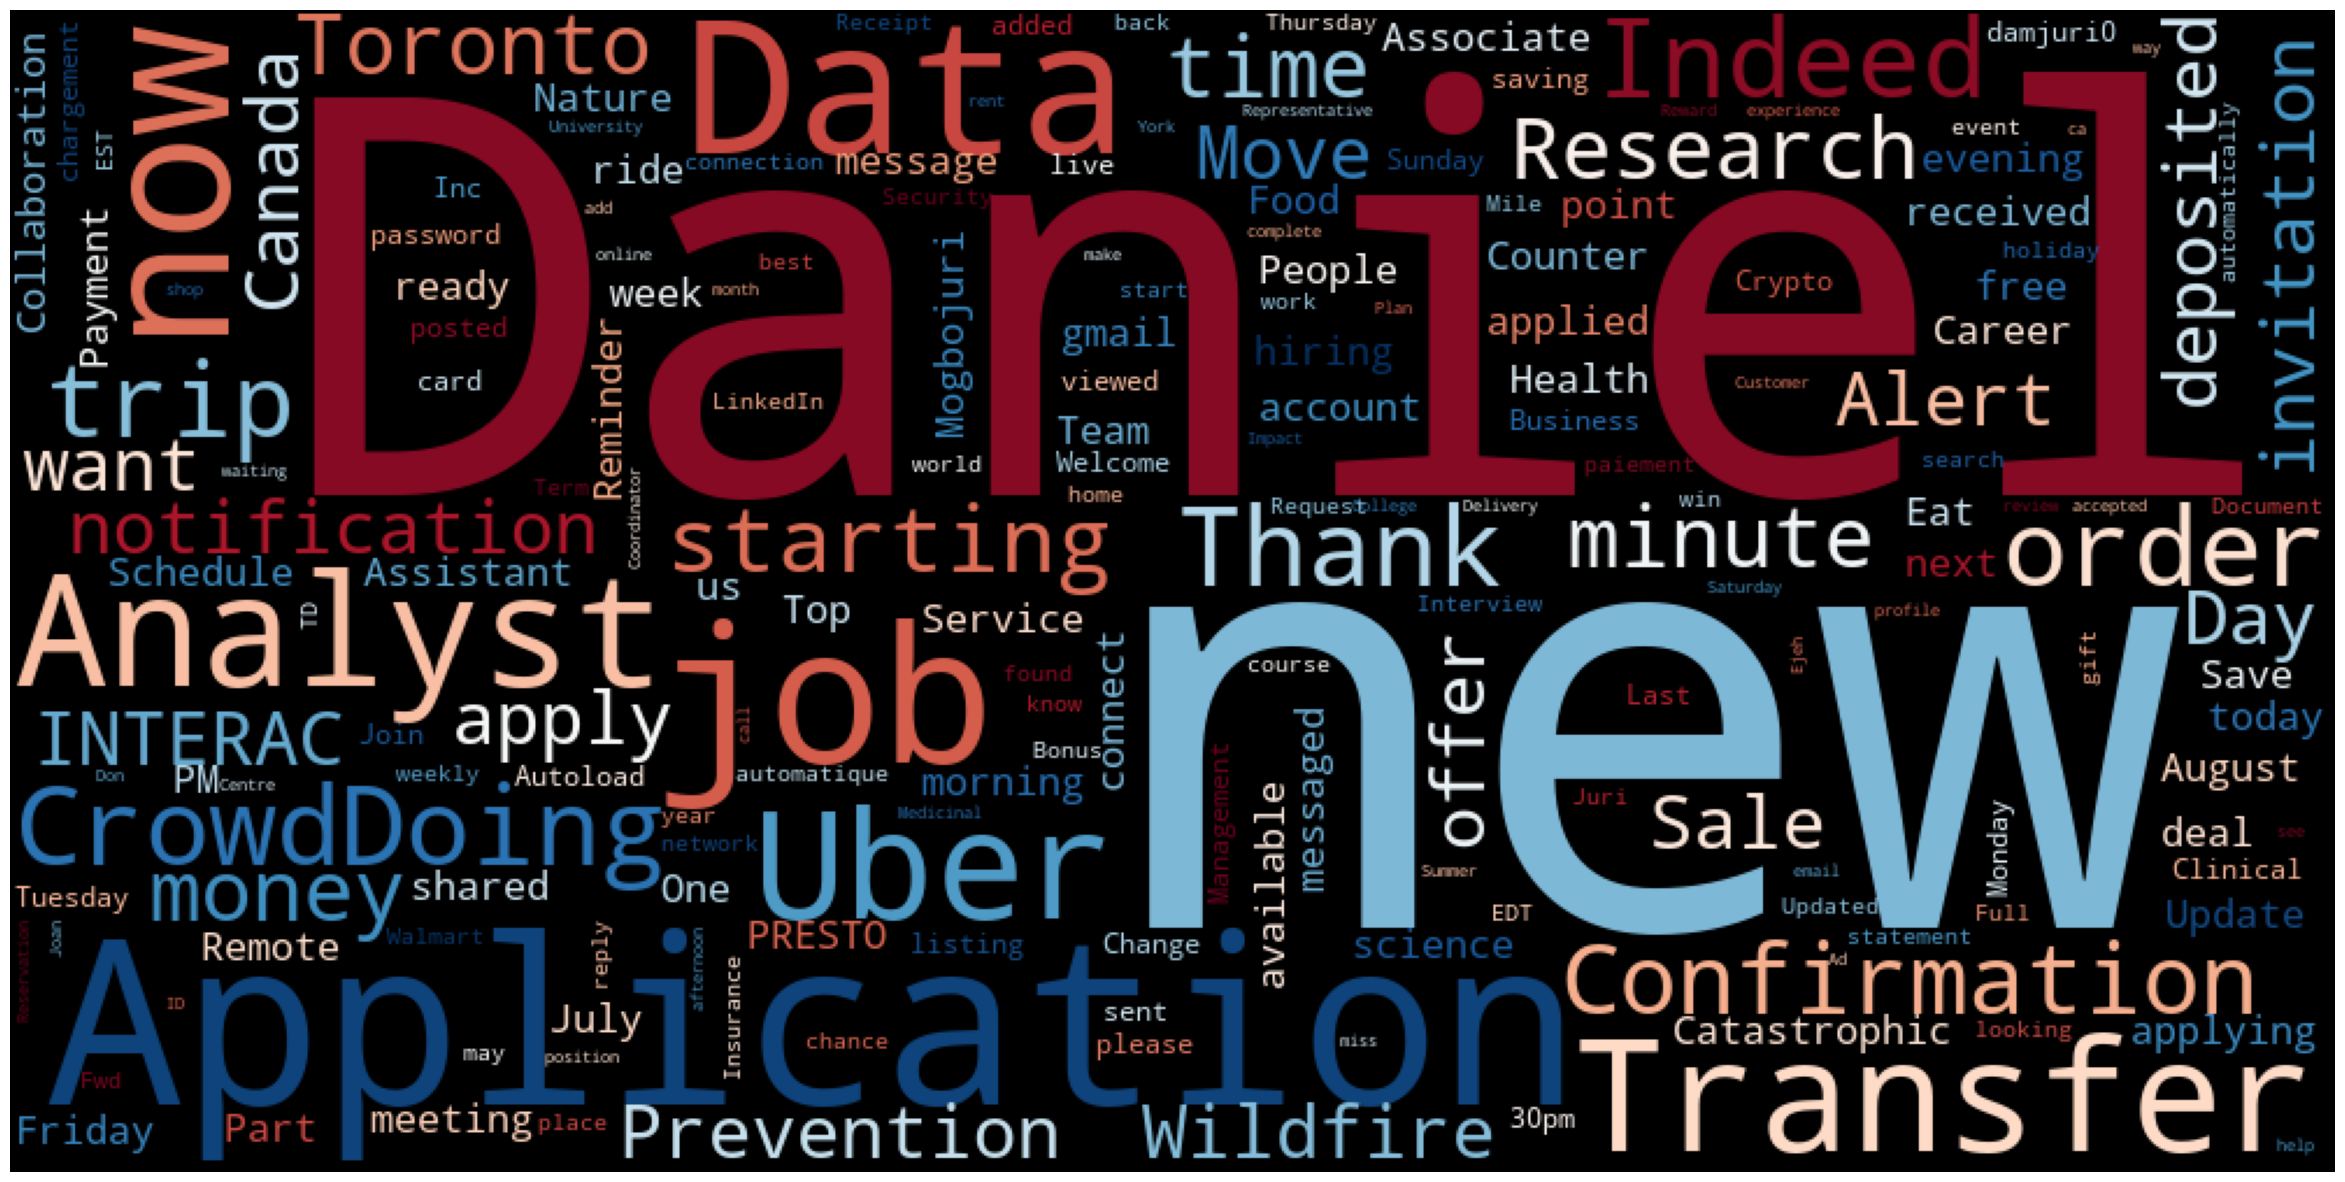

In [119]:
# Convert all values to strings in the 'New_Subject' column
text = " ".join(str(subject_titles) for subject_titles in email_df['New_Subject'])

stopwords = set(STOPWORDS)
stopwords.update(['Re', 'de', 'Hi', 'got', 'hello', 'du', 'u', 'e', 's', 't'])

# Generate word cloud
word_cloud = WordCloud(stopwords=stopwords,collocations=False, background_color='black', colormap='RdBu', min_font_size=2, scale=2.5).generate(text)

# Display the word cloud
plt.figure(figsize=(30, 20))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()


**CONCLUSION**
- LinkedIn is the most frequent account I receive emails from
- In 2023 I received the most emails and counting. 
- 2014 is the year I received the least amount of emails which makes sense since its the year I made my email
- Tuesday is the weekday I receive the most emails, while Saturday is the day I receive the least amount of emails
- I received the most emails at the 17h-18h mark with the 17-19h range being a more accurate range where I receive the most emails
- In 2023 Uber receipts was the most frequent account I receive emails from. About 77% of the total emails I received from Uber Receipts came in 2023. Also, About 53.7% of emails received from Adidas were received in 2023. This shows a possible spike in patterns on my Uber and Adidas accounts
- August is the month with the most frequency of emails received. January and October had very close numbers of frequency
- In 2023, January was the month I received the most emails. 2023 alone made about 62% of my total emails received in January. Showed a significant spike in pattern
- My name (Daniel) was the most frequent subject from my Inbox. 
- With all these information, I can target the most frequent email accounts that I deem unwanted, delete them and track what websites/accounts I can unsubscribe from to free up my Inbox 